In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from tqdm import tqdm
from mug_cakes import bo, gp, kernel
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from mug_cakes import utils

In [3]:
# pick parameters for GP
s2f = 15
scale = 0.05
s2e = 1**2
x_true = np.array([s2f, scale, s2e])
J = 2
var_b = 5**2

In [4]:
# def closure():
#     eps = 0.000001
#     xa = (res.x + 1).copy()
#     xb = xa.copy()
#     xb[1] += eps
#     est = (bo._hp_target(xb, X, Y, 2, B, var_b) - bo._hp_target(xa, X, Y, 2, B, var_b)) / eps
#     print(bo._dhp_target(xa, X, Y, 2, B, var_b))
#     print(est)
#     # N = X.shape[0]
#     # log_s2f, log_scale, log_s2e = x0
#     # s2f = np.exp(log_s2f)
#     # scale = np.exp(log_scale)
#     # s2e = np.exp(log_s2e)
#     # K = kernel.rbf(X, X, scale, s2f)
#     # vara = bo.full_cov(K[None], 2, s2e, 1)[0, :N, :N]
#     # varb = bo.full_cov(K[None], 2, s2e + eps, 1)[0, :N, :N]
#     # print((varb - vara)/eps)
#     # print(bo.full_cov(np.zeros((N,N)), 2, 1, 0)[0, :N, :N])
# closure()

In [5]:
%%time
N = 20 * J
P = 50
bounds = ((-1, 4), (-7, 4), (-7, 4))
# running_sum = 0
# for _ in tqdm(range(P)):
#     x_0 = np.array([0, 0, 0])
#     X = np.linspace(0,1, N // J).reshape(-1, 1)
#     X = utils.rowpeat(X, 2)
#     K = kernel.rbf(X, X, scale, s2f)
#     var = bo.full_cov(K, 2, s2e, var_b)
#     Y = stats.multivariate_normal.rvs(cov = var)[:N]
#     res = scipy.optimize.minimize(target, x0, method='L-BFGS-B', jac=dtarget, options={'disp': False}, args = (X,Y,2,var_b), bounds=bounds)
#     running_sum += np.exp(res.x)
# print(running_sum / P, x_true)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [8]:
N = 5 * J

# sample data
X = np.linspace(0, 1, N // J).reshape(-1, 1)
X = np.random.rand(N, 1)
B = np.zeros(N, dtype=np.uint64)
B[: N // 2] = 1
X[: N // 2] -= 0.5
# X = utils.rowpeat(X, J)
K = kernel.rbf(X, X, scale, s2f)
var = bo.full_cov(K, J, B, s2e, var_b)
Y = stats.multivariate_normal.rvs(cov=var)[:N]
# Y *= 0
# Y[::2] =3
# Y[1::2] =-3

# fit hyperparameters
x0 = np.array([0, 0, 0])
# res = scipy.optimize.minimize(target, x0, method='L-BFGS-B', jac=dtarget, options={'disp': False}, args = (X,Y,J,var_b), bounds=bounds)

[1.85622676 0.00877606 0.46324325]


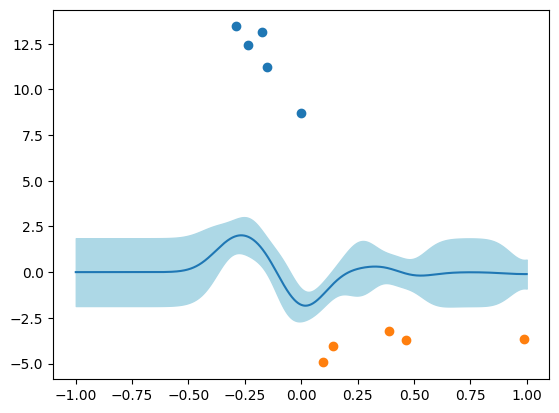

In [9]:
hparams_mle = bo.optimize_rbf_params(X, Y, J, B, var_b)
# hparams_mle[0] = 100
N_star = 1000
X_star = np.linspace(-1, 1, N_star).reshape(-1, 1)
K = kernel.rbf(X, X, hparams_mle[1], hparams_mle[0])
var = bo.full_cov(K, J, B, hparams_mle[2], var_b)[:N, :N]
K_star = kernel.rbf(X, X_star, hparams_mle[1], hparams_mle[0])
K_2star = kernel.rbf(X_star, X_star, hparams_mle[1], hparams_mle[0])
post_mean2 = gp.conditional_mean(Y, np.linalg.inv(var), K_star.T)
post_var2 = gp.conditional_var(K_2star, np.linalg.inv(var), K_star.T)
print(hparams_mle)

plt.fill_between(
    X_star.reshape(-1),
    post_mean2 - post_var2,
    post_mean2 + post_var2,
    color="lightblue",
)
plt.plot(X_star, post_mean2)
plt.scatter(X[B == 1], Y[B == 1])
plt.scatter(X[B == 0], Y[B == 0])

array([-0.26726727])

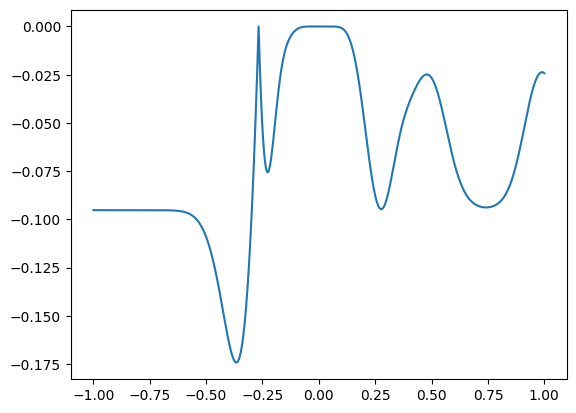

In [10]:
x_M = X_star[post_mean2.argmax()]
s2f_map, scale2_map, s2e_map = hparams_mle
eis = []
for i in X_star:
    x_s = i
    eis.append(
        bo.minus_expected_diff(
            x_s, x_M, X, Y, np.linalg.inv(var), scale2_map, s2f_map, lambda_=1, gamma=1
        )
    )
plt.plot(X_star, eis)
x_M

In [11]:
x0 = np.array([0])
res = scipy.optimize.basinhopping(
    bo.minus_expected_diff,
    x0,
    # method="L-BFGS-B",
    minimizer_kwargs={
        "jac": bo.dminus_expected_diff,
        "options": {"disp": False},
        "args": (x_M, X, Y, np.linalg.inv(var), scale2_map, s2f_map),
        "bounds": ((-0.4, 1),),
    },
    # disp = True,
)

In [13]:
xs = np.array([0])
bo.minus_expected_diff(
    x_s, x_M, X, Y, np.linalg.inv(var), scale2_map, s2f_map, lambda_=0, gamma=0
)

-0.0025369532711494273

In [14]:
# B1 = np.zeros_like(Y, dtype=np.uint64)

# hparams_mle = bo.optimize_rbf_params(X, Y, J, B1, var_b)
# X_star = np.linspace(X.min(), X.max(), N_star).reshape(-1, 1)
# K = kernel.rbf(X, X, hparams_mle[1], hparams_mle[0])
# var = bo.full_cov(K, 1, B1, hparams_mle[2], var_b)[:N, :N]
# K_star = kernel.rbf(X, X_star, hparams_mle[1], hparams_mle[0])
# K_2star = kernel.rbf(X_star, X_star, hparams_mle[1], hparams_mle[0])
# post_mean = gp.conditional_mean(Y, np.linalg.inv(var), K_star.T)
# post_var = gp.conditional_var(K_2star, np.linalg.inv(var), K_star.T)
# print(hparams_mle)

# plt.fill_between(X_star.reshape(-1), post_mean - post_var, post_mean + post_var, color="lightblue")
# plt.scatter(X[B == 1], Y[B == 1])
# plt.scatter(X[B == 0], Y[B == 0])
# plt.plot(X_star, post_mean)

In [15]:
x_s = np.array([2])
x_M = np.array([0.1])
eps = 0.000001
kwargs = {"gamma": 0, "lambda_": 0}
(
    bo.minus_expected_diff(
        x_s + eps, x_M, X, Y, np.linalg.inv(var[:N, :N]), scale, s2f, **kwargs
    )
    - bo.minus_expected_diff(
        x_s, x_M, X, Y, np.linalg.inv(var[:N, :N]), scale, s2f, **kwargs
    )
) / eps

-0.0006304201605189519

In [46]:
X_star[np.argmax(target(np.hstack((X_star, 1 - X_star)))[:300])]

array([0.16616617])

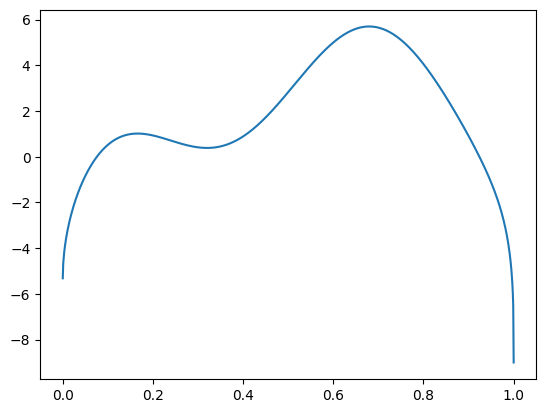

In [40]:
def target(x):
    return (
        2 * np.sin(10 * x[..., 0] + 1)
        + 20 * x[..., 0] ** 0.5
        + 20 * (x[..., 1]) ** 0.3
        - 27
    )


X_star = np.linspace(0, 1, 1000).reshape(-1, 1)
plt.plot(X_star, target(np.hstack((X_star, 1 - X_star))))

In [50]:
s2e = 0.4**2
bb = np.array([-2.0, 2.0, 0])
var_b = 1**2
N_b = 3
N = 3
X = np.random.rand(N, 1)
X = np.hstack((X, 1 - X))
B = np.array([0, 1, 2], dtype=np.uint64)
y = (target(X) + np.random.normal(size=(X.shape[0])) * s2e**0.5) + bb[B]
# y *= 0
state = bo.BoState(X, y, N_b, B, var_b, simplex=True)
N_star = 1000
X_star = np.linspace(0, 1, N_star).reshape(-1, 1)
X_star = np.hstack((X_star, 1 - X_star))

In [51]:
for _ in tqdm(range(30)):
    x_new, (s2f_map, scale2_map, s2e_map), x_M = bo.bo_iter(state)
    j = np.random.choice(N_b)
    y_new = target(x_new) + bb[j] + np.random.normal() * s2e**0.5
    np.array(j, dtype=np.uint64)
    state.add(x_new, y_new, j)

100%|██████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.87it/s]


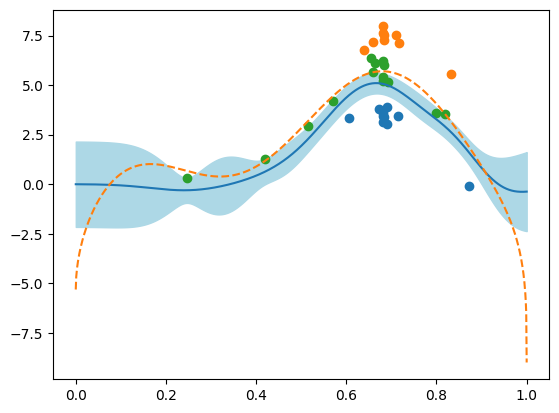

In [52]:
K = kernel.rbf(state.X, state.X, scale2_map, s2f_map)
var = bo.full_cov(K, state.N_b, state.B, s2e_map, state.var_b)[: state.N, : state.N]
K_star = kernel.rbf(state.X, X_star, scale2_map, s2f_map)
K_2star = kernel.rbf(X_star, X_star, scale2_map, s2f_map)
post_mean2 = gp.conditional_mean(state.y, np.linalg.inv(var), K_star.T)
post_var2 = gp.conditional_var(K_2star, np.linalg.inv(var), K_star.T)

plt.fill_between(
    X_star[:, 0],
    post_mean2 - post_var2**0.5,
    post_mean2 + post_var2**0.5,
    color="lightblue",
)
plt.plot(X_star[:, 0], post_mean2)
plt.scatter(state.X[state.B == 0, 0], state.y[state.B == 0])
plt.scatter(state.X[state.B == 1, 0], state.y[state.B == 1])
plt.scatter(state.X[state.B == 2, 0], state.y[state.B == 2])
plt.plot(X_star[:, 0], target(X_star), "--");

In [53]:
x_M

array([0.66352745, 0.33647255])

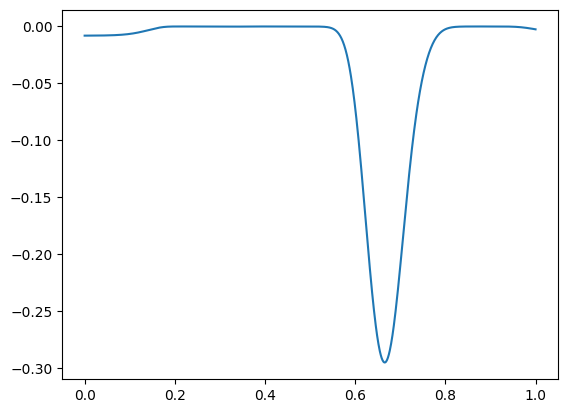

In [54]:
# x_M = X_star[post_mean2.argmax()]
eis = []
for i in X_star:
    x_s = i
    eis.append(
        bo.minus_expected_diff(
            x_s,
            x_M,
            state.X,
            state.y,
            np.linalg.inv(var),
            scale2_map,
            s2f_map,
            lambda_=0,
            gamma=1,
        )
    )
plt.plot(X_star[:, 0], eis)

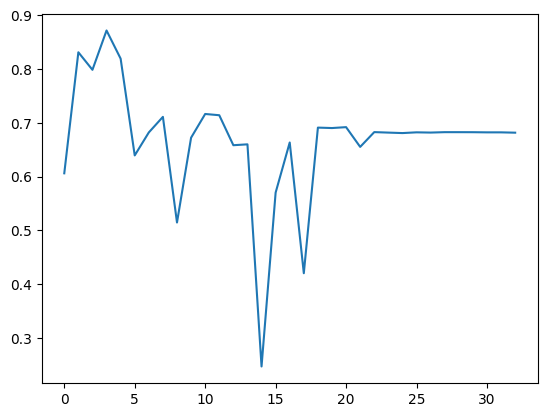

In [55]:
plt.plot(state.X[:, 0])